# Logitboost Assignment
Implement Logitboost using 1D linear regressors as weak learners. At each boosting
iteration choose the weak learner that obtains the largest reduction in the loss function
on the training set $D = {(x_i, y_i), i = 1, ..., N}, \text{ with } y_i ∈ {0, 1}$:


#### Import dependencies

In [355]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.special import expit

#### Data loading functions

In [356]:
def get_gisette():
    path = "data/gisette/"   
    
    train_x = np.loadtxt(path+"gisette_train.data")
    train_y = np.loadtxt(path+"gisette_train.labels")
    
    valid_x = np.loadtxt(path+"gisette_valid.data")
    valid_y = np.loadtxt(path+"gisette_valid.labels")
    
    return train_x, train_y, valid_x, valid_y



def get_dexter():
    path = "data/dexter/"

    train_x = np.loadtxt(path+"dexter_train.csv", delimiter=',')
    train_y = np.loadtxt(path+"dexter_train.labels")

    valid_x = np.loadtxt(path+"dexter_valid.csv", delimiter=',')
    valid_y = np.loadtxt(path+"dexter_valid.labels")

    return train_x, train_y, valid_x, valid_y

def get_madelon():
    path = "data/MADELON/"

    train_x = np.loadtxt(path + "madelon_train.data")
    train_y = np.loadtxt(path + "madelon_train.labels")
    test_x = np.loadtxt(path + "madelon_valid.data")
    test_y = np.loadtxt(path + "madelon_valid.labels")

    return train_x, train_y, test_x, test_y

#### Normalization function

In [357]:
def normalize(train, *args):
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)


def beta_selection(x, beta0, beta1, y, h):

    h_prediction = np.sum(x * h[:,1] + h[:,0], axis=1)
    #h_prediction = np.zeros_like(h_prediction)
    new_beta1s = np.diag(beta1) # create diagonal p x p matrix
    beta_predictions = np.dot(x,new_beta1s) + beta0
    final_prediction = beta_predictions+h_prediction[np.newaxis].T
    #loss=np.sum(np.log(1+np.exp(-ytilde*final_prediction.T)), axis=1)
    ytilde=2*y-1
    #print(np.max(beta_predictions))
    final_prediction = np.clip(final_prediction, -100, 100)
    loss=np.sum(np.log(1+np.exp(-ytilde*final_prediction.T)), axis=1)
    #print("loss min", np.min(loss))
    #print("loss max", np.max(loss))

    #loss[selected] = np.inf
    beta_index = np.argmin(loss)
    selected.append(beta_index)
    #print("beta_index", beta_index)
    #print("selected value", loss[beta_index])
    #print("slected", loss[beta_index])
    filter = np.zeros_like(beta0) # array of ones of same length as beta0
    filter[beta_index] = 1 # set the spot at beta_index to 0
    beta0[filter==0] = 0 # all indices at which filter==1 are set to 0, to beta 0 has zeroes everywhere except beta_index
    beta1[filter==0] = 0
    return np.column_stack(np.dstack((beta0,beta1)))


#def h()
# I separated linear regression to its own function and transposed to vectors so they
# broadcast correctly
def linear_regressor_for_each_feature(x, y, w):
    print("max z", np.max(y))
    print("min z", np.min(y))
    #print(y)
    mean_x = w @ x / np.sum(w)
    mean_y = np.sum(w*y) / np.sum(w)
    #print("x", x)
    #print("mean_x", mean_x)
    #print("mean_y", mean_y)
    #print(y)
    denominators = w @ np.square(x-mean_x)
    #print("denom",denominators)
    print("numerator",np.max(w*(y-mean_y)@(x-mean_x)))
    print("max, denominator",np.max(denominators))
    #print(denominators)
    beta_1= np.divide((w*(y-mean_y))@(x-mean_x), denominators, where=~np.isclose(denominators,0))
    print("test", np.max(np.abs(beta_1)))
    print("test2", np.min(np.abs(beta_1)))
    index = np.isnan(beta_1)
    #print("index", index[0])
    #print("value", beta_1[index])
    #print("denominator", denominators[index])
    #print("nan", np.sum(denominators.size- np.count_nonzero(denominators)))
    #print("nan",np.sum(np.isnan(y)))
    #print("nan beta1",np.sum(np.isnan(beta_1)))
    #print("inf beta1",np.where(beta_1==np.inf)[0].size)
    beta_0 = mean_y + beta_1 * mean_x
    return beta_0, beta_1


In [358]:
selected = []
def train_logit(train_x, train_y, test_x, test_y, iterations):
    train_y[train_y==-1] = 0
    test_y[test_y==-1] = 0
    trainscore=[]
    testscore=[]
    h = np.zeros([train_x.shape[1],2])

    np.seterr("raise")
    for _ in range(iterations):
        #print("nonzero", np.count_nonzero(h))
        h_xi= np.sum(train_x * h[:,1] + h[:,0], axis=1)
        p=expit(h_xi)
        p[p==1]=.999
        p[p==0]=.001
        w_i=(p)*(1-p)
        denominator = (p*(1-p))
        z = np.divide((train_y - p),denominator)
        #print("nan z",np.sum(np.isnan(z)))
        #print("min", np.min(z))
        #print("max", np.max(z))
        plt.hist(z)
        plt.show()
        Beta0, Beta1 = linear_regressor_for_each_feature(train_x, z, w_i)
        selected_betas= beta_selection(train_x, Beta0, Beta1, train_y, h)
        h += selected_betas
        trainscore.append(1-accuracy_score(train_y, predict(train_x, h[:,1], h[:,0])))
        testscore.append(1-accuracy_score(test_y, predict(test_x, h[:,1], h[:,0])))

    return trainscore, testscore

In [359]:
def predict(x, b1, b0):
    prediction = np.sum(x*b1 + b0, axis=1)
    prediction[prediction >= 0] = 1
    prediction[prediction < 0] = 0
    return prediction

In [360]:
def plot(train_errors, test_errors, iteration, train_error_to_plot, test_error_to_plot):
    i = list(range(len(test_error_to_plot)))
    plt.plot(i, train_error_to_plot)
    plt.plot(i, test_error_to_plot)
    plt.legend(["Train", "Test"])
    plt.xlabel("Iterations")
    plt.ylabel("Misclassification error")
    plt.title("Error vs iterations with 100 features")

    test_errors = [f"{test_error:.3f}" for test_error in test_errors]
    train_errors = [f"{train_error:.3f}" for train_error in train_errors]
    plt.table(cellText=[*zip(iteration, train_errors, test_errors)], colLabels=['Iteration', 'Training error', 'Test error'],
              bbox=[0.0,-0.8, 1,.4], edges="closed" )
    plt.show()

def plot_logit(xtrain, ytrain, xtest, ytest):
    error_test=[]
    error_train=[]

    iterations=[50]
    plot_train_error=[]
    plot_test_error=[]

    for x in iterations:
        trainscore, testscore = train_logit(xtrain, ytrain, xtest, ytest, x)
        error_train.append(trainscore[-1])
        error_test.append(testscore[-1])
        if x == 50 :
            plot_train_error = trainscore
            plot_test_error = testscore
    plot(error_train, error_test, iterations, plot_train_error, plot_test_error)

#### Plot the error vs iteration and display final error in a table

## a) Gisette

Using the Gisette data, train a Logitboost classifier on the training set, with k ∈ {10, 30, 100, 300, 500} boosted iterations. Plot the training loss vs iteration number for k = 500. Report in a table the misclassification errors on the training and test set for the models obtained for all these k. Plot the misclassification errors on the training and test set vs k. (5 points)

In [361]:
#train_x, train_y, test_x, test_y = get_gisette()

In [362]:
#plot_logit(train_x, train_y, test_x, test_y)

## b) Dexter
Repeat point a) on the dexter dataset

In [363]:
#train_x, train_y, test_x, test_y = get_dexter()

In [364]:
#plot_logit(train_x, train_y, test_x, test_y)

## c) Madelon
Repeat point a) on the madelon dataset

In [365]:
train_x, train_y, test_x, test_y = get_madelon()

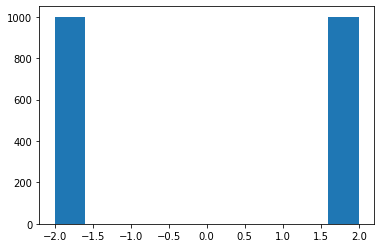

max z 2.0
min z -2.0
numerator 16985.000000000004
max, denominator 9047939.127999999
test 0.0815717828220651
test2 5.361693428802525e-06
max z 2.006324478893596
min z -1.995192220326757
numerator 16985.107561592915
max, denominator 9047869.449612694
test 0.08157363037271816
test2 4.126014921121778e-11
max z 2.0007516305251656
min z -2.000734098777021
numerator 16985.10755993598
max, denominator 9047939.017179178
test 0.08157299925106029
test2 4.1335198257942674e-11
max z 2.0007517504934897
min z -2.000733990269067
numerator 16985.10756076522
max, denominator 9047939.017181296
test 0.08157299926049233
test2 5.562180216692695e-19
max z 2.000751707650195
min z -2.0007340331116032
numerator 16985.10756076519
max, denominator 9047939.017179858
test 0.08157299926047515
test2 1.2191079926996375e-19
max z 2.0007517076501946
min z -2.0007340331116037
numerator 16985.10756076519
max, denominator 9047939.017179858
test 0.08157299926047515
test2 5.028820469886005e-19
max z 2.000751707650195
min z 

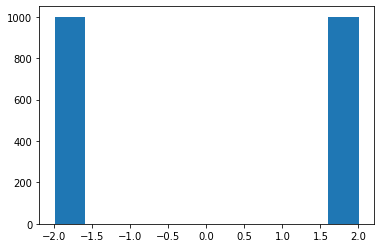

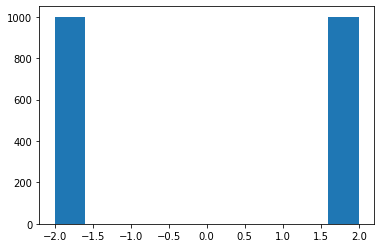

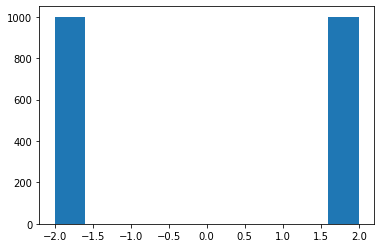

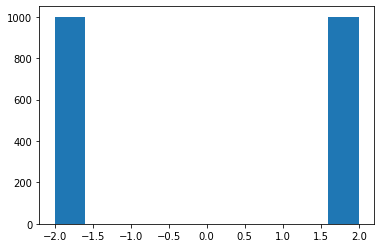

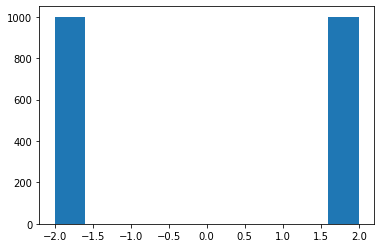

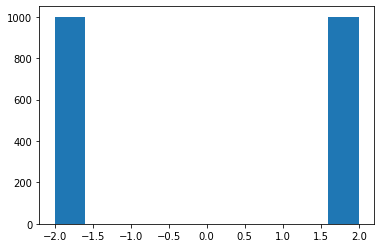

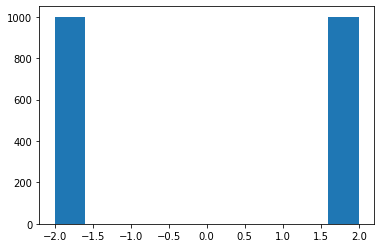

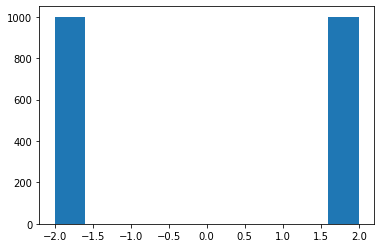

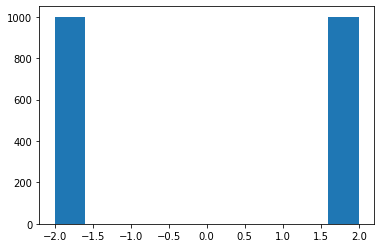

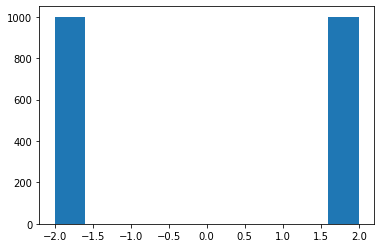

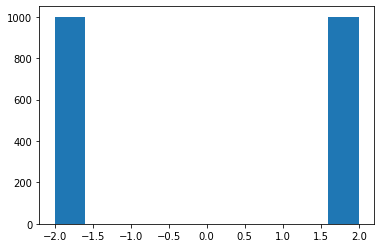

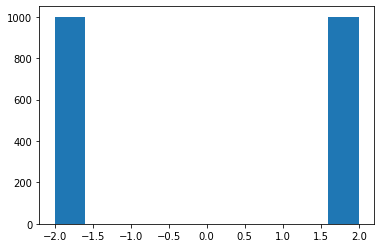

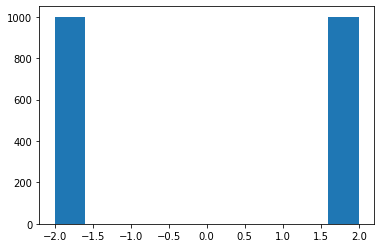

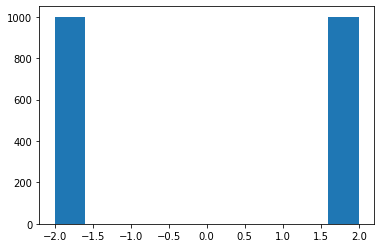

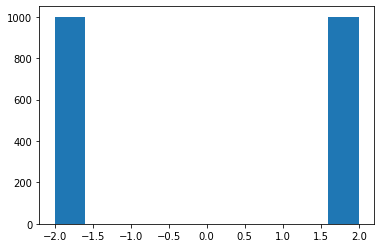

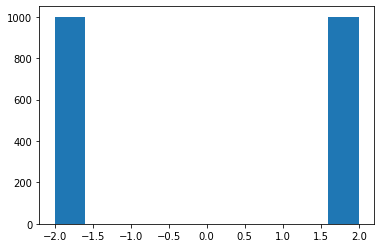

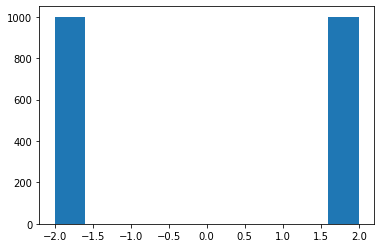

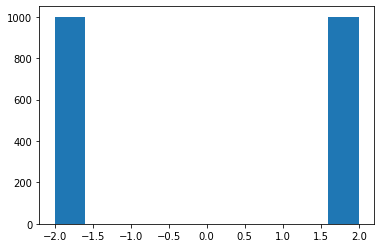

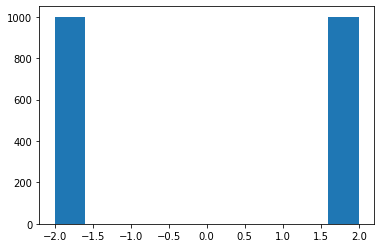

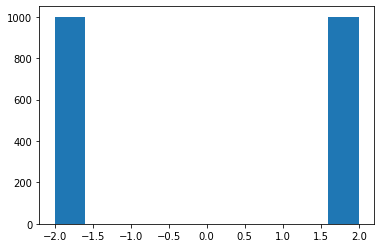

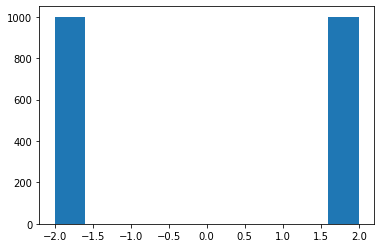

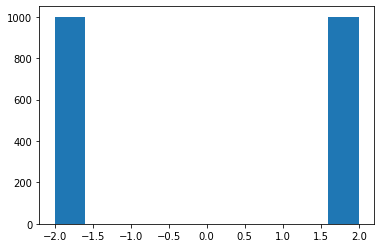

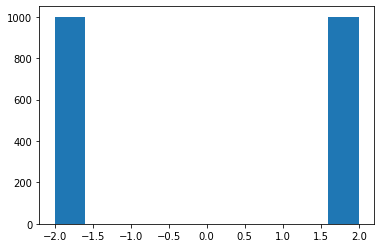

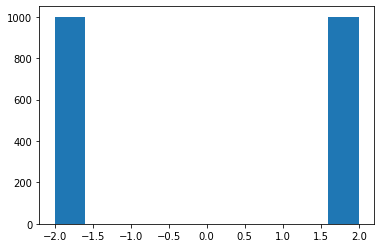

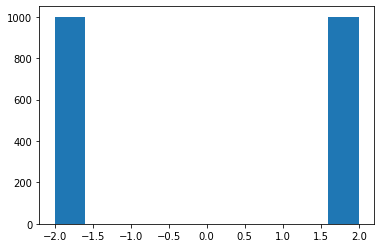

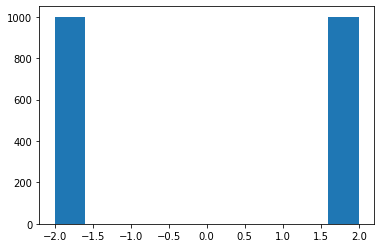

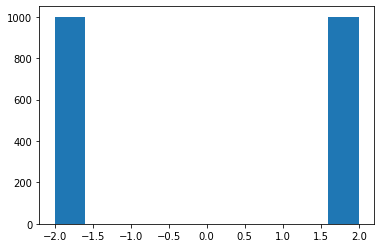

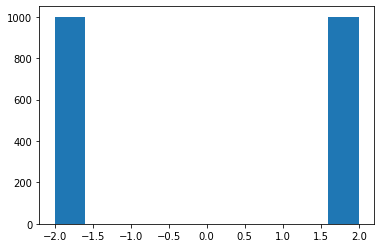

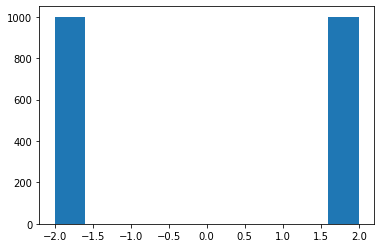

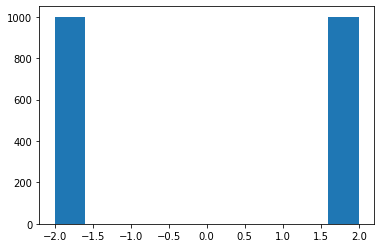

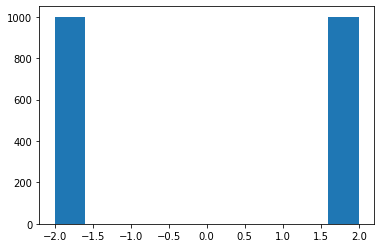

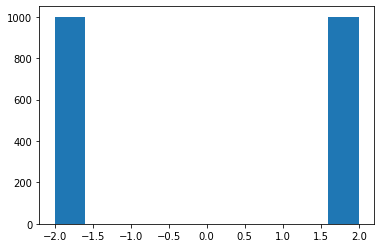

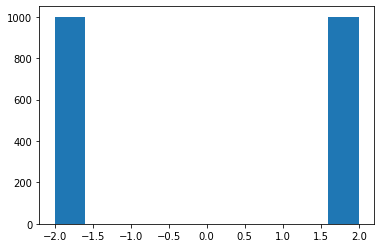

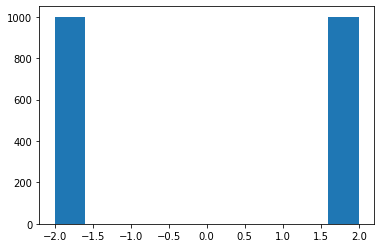

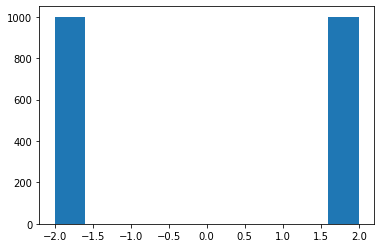

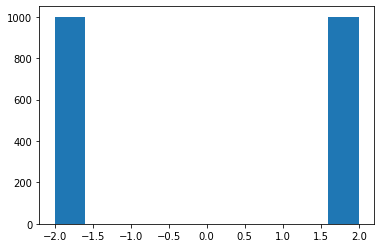

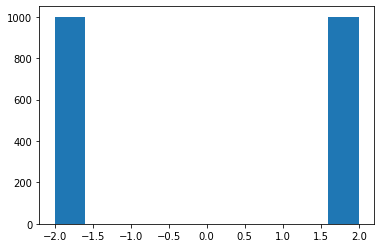

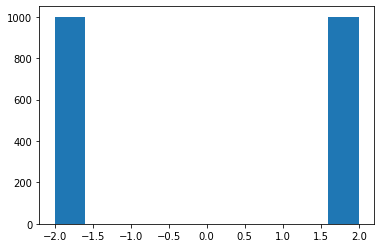

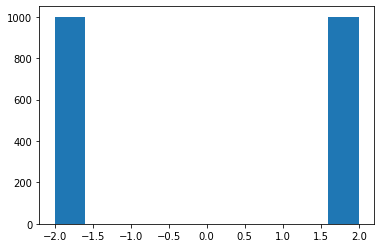

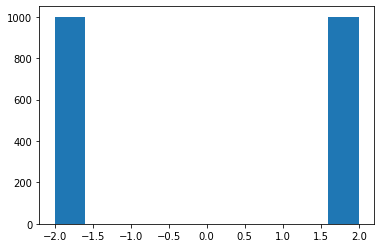

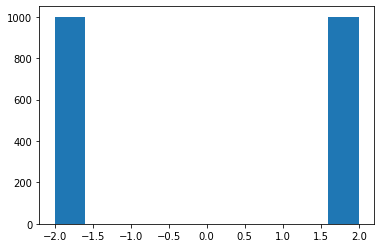

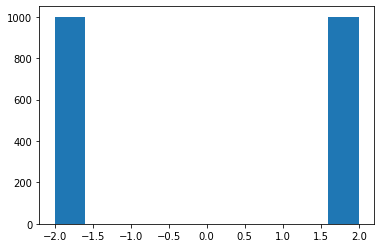

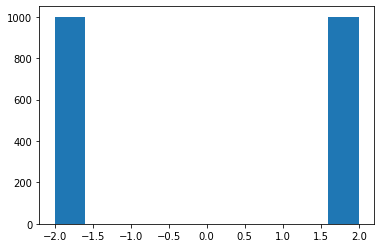

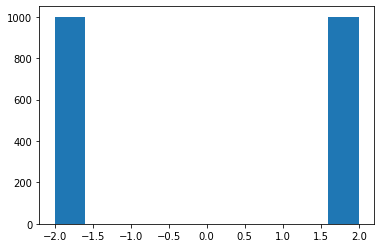

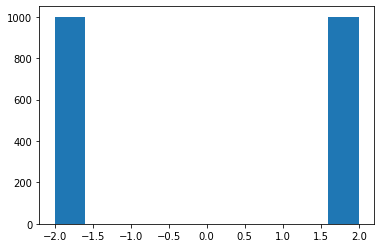

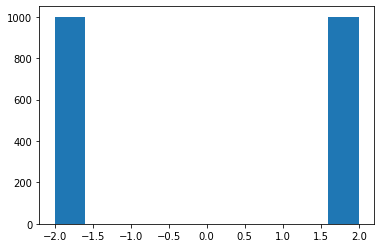

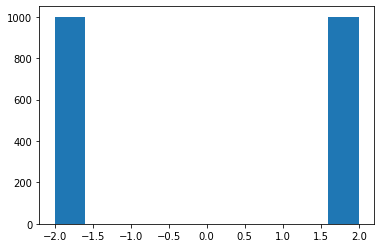

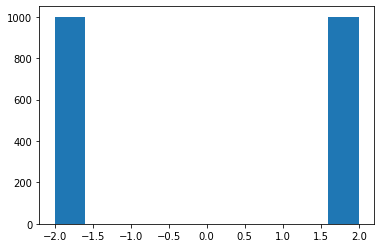

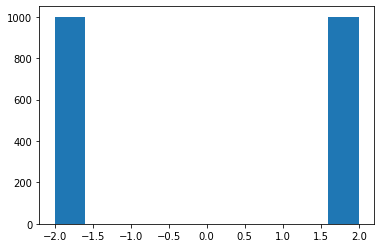

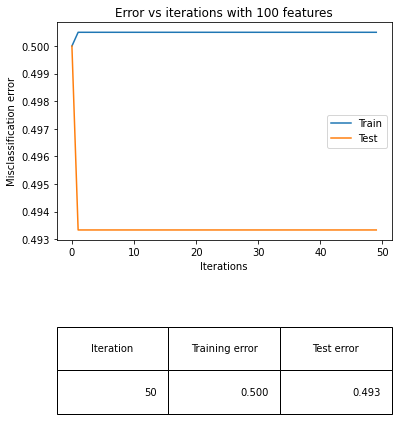

In [366]:
plot_logit(train_x, train_y, test_x, test_y)
